In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

DATASET_PATH = "/content/drive/MyDrive/Violence Detection/dataset"
print(os.listdir(DATASET_PATH))

['real life violence situations', 'Real Life Violence Dataset']


# **Install & import libraries**

In [ ]:
!pip install opencv-python

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


# **Collect video paths and labels**

In [ ]:
# Two main folders inside dataset
datasets = ['Real Life Violence Dataset', 'real life violence situations']
classes = ['Violence', 'NonViolence']  # Note: check exact spelling

video_paths = []
labels = []

valid_exts = ('.mp4', '.avi', '.mov', '.mkv')

for d in datasets:
    for c in classes:
        folder = os.path.join(DATASET_PATH, d, c)
        if not os.path.exists(folder):
            print("Missing folder:", folder)
            continue

        for f in os.listdir(folder):
            if f.lower().endswith(valid_exts):
                full_path = os.path.join(folder, f)
                video_paths.append(full_path)
                labels.append(1 if c.lower() == 'violence' else 0)

print("Total videos:", len(video_paths))
print("Violence videos:", sum(labels))
print("Nonviolence videos:", len(labels) - sum(labels))


Total videos: 4001
Violence videos: 2000
Nonviolence videos: 2001


**Code to randomly sample 500 videos from each class**

In [ ]:
video_paths = [...]
labels = [...]

In [ ]:
import os
import numpy as np

DATASET_PATH = "/content/drive/MyDrive/Violence Detection/dataset"

video_paths = []
labels = []

valid_exts = ('.mp4', '.avi', '.mov', '.mkv')

# Walk through the two main dataset folders
for main_folder in os.listdir(DATASET_PATH):
    main_path = os.path.join(DATASET_PATH, main_folder)
    if not os.path.isdir(main_path):
        continue

    print("Scanning main folder:", main_path)

    # Inside each main folder, expect class folders like "Violence", "NonViolence", "Nonviolence"
    for class_folder in os.listdir(main_path):
        class_path = os.path.join(main_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        print("  Found class folder:", class_path)

        # Decide label based on class folder name (case-insensitive, tolerant)
        name_clean = class_folder.lower().replace(" ", "")

        if "non" in name_clean and "violence" in name_clean:
            label_value = 0  # Non-violence
        elif "violence" in name_clean:
            label_value = 1  # Violence
        else:
            print("  ⚠ Skipping folder (unknown class):", class_folder)
            continue

        # Collect all video files in this class folder
        for f in os.listdir(class_path):
            if f.lower().endswith(valid_exts):
                full_path = os.path.join(class_path, f)
                video_paths.append(full_path)
                labels.append(label_value)

print("\nTotal videos found:", len(video_paths))
print("Violence videos:", sum(labels))
print("Non-violence videos:", len(labels) - sum(labels))


Scanning main folder: /content/drive/MyDrive/Violence Detection/dataset/real life violence situations
  Found class folder: /content/drive/MyDrive/Violence Detection/dataset/real life violence situations/NonViolence
  Found class folder: /content/drive/MyDrive/Violence Detection/dataset/real life violence situations/Violence
Scanning main folder: /content/drive/MyDrive/Violence Detection/dataset/Real Life Violence Dataset
  Found class folder: /content/drive/MyDrive/Violence Detection/dataset/Real Life Violence Dataset/NonViolence
  Found class folder: /content/drive/MyDrive/Violence Detection/dataset/Real Life Violence Dataset/Violence

Total videos found: 4001
Violence videos: 2000
Non-violence videos: 2001


In [ ]:
# Convert lists to numpy arrays
video_paths = np.array(video_paths)
labels = np.array(labels)

# Get indices for each class
violence_indices = np.where(labels == 1)[0]
nonviolence_indices = np.where(labels == 0)[0]

print("Violence videos available:", len(violence_indices))
print("Non-violence videos available:", len(nonviolence_indices))

# Randomly select up to 500 from each class
violence_selected = np.random.choice(
    violence_indices,
    size=min(500, len(violence_indices)),
    replace=False
)

nonviolence_selected = np.random.choice(
    nonviolence_indices,
    size=min(500, len(nonviolence_indices)),
    replace=False
)

# Combine and shuffle selected indices
selected_indices = np.concatenate([violence_selected, nonviolence_selected])
np.random.shuffle(selected_indices)

# Filter dataset down to selected subset
video_paths = video_paths[selected_indices].tolist()
labels = labels[selected_indices].tolist()

print("\nFinal selected dataset size:", len(video_paths))
print("Violence count:", sum(labels))
print("Non-violence count:", len(labels) - sum(labels))


Violence videos available: 2000
Non-violence videos available: 2001

Final selected dataset size: 1000
Violence count: 500
Non-violence count: 500


# **Train / validation split (video-based)**

In [ ]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    video_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print("Train videos:", len(train_paths))
print("Val videos:", len(val_paths))


Train videos: 800
Val videos: 200


## **Define frame extraction**
We’ll sample a few frames per video (to reduce RAM and time).

Resize frames to 112×112

Use 5 frames per video to start

In [ ]:
IMG_SIZE = 112
FRAMES_PER_VIDEO = 5

def extract_frames(video_path, num_frames=FRAMES_PER_VIDEO, img_size=IMG_SIZE):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count <= 0:
        cap.release()
        return np.array([])

    # Pick evenly spaced indices
    indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)

    frames = []
    current_idx = 0
    target_idx_set = set(indices)
    collected = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if current_idx in target_idx_set:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (img_size, img_size))
            frame = frame.astype('float32') / 255.0  # normalize
            frames.append(frame)
            collected += 1

            if collected == num_frames:
                break

        current_idx += 1

    cap.release()
    return np.array(frames)


Test it quickly on one video:

In [ ]:
test_frames = extract_frames(train_paths[0])
print("Frames shape:", test_frames.shape)   # expected: (FRAMES_PER_VIDEO, Pixel length, Pixel width, RGB Channel)


Frames shape: (5, 112, 112, 3)


# Convert videos → frame dataset

Each video gives multiple frames.

Each frame gets the same label as the video.

In [ ]:
def prepare_data(video_paths, labels):
    X = []
    y = []

    for path, label in zip(video_paths, labels):
        frames = extract_frames(path)
        if frames.size == 0:
            continue

        for f in frames:
            X.append(f)
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = prepare_data(train_paths, train_labels)
X_val, y_val   = prepare_data(val_paths, val_labels)

print("Train frames:", X_train.shape, y_train.shape)
print("Val frames:", X_val.shape, y_val.shape)


Train frames: (3995, 112, 112, 3) (3995,)
Val frames: (1000, 112, 112, 3) (1000,)


# Build the MobileNetV2 Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 backbone (pretrained on ImageNet)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model layers so they don't retrain initially
for layer in base_model.layers:
    layer.trainable = False

# Build the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary output: violence probability
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/tmp/ipython-input-3832090611.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train the Model

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - accuracy: 0.6456 - loss: 0.6808 - val_accuracy: 0.8100 - val_loss: 0.4224
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8151 - loss: 0.3912 - val_accuracy: 0.8410 - val_loss: 0.3619
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8682 - loss: 0.3152 - val_accuracy: 0.8530 - val_loss: 0.3444
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8844 - loss: 0.2699 - val_accuracy: 0.8530 - val_loss: 0.3307
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9033 - loss: 0.2468 - val_accuracy: 0.8620 - val_loss: 0.3017
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9233 - loss: 0.2097 - val_accuracy: 0.8660 - val_loss: 0.2894
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9265 - loss: 0.1900 - val_accuracy: 0.8680 - val_loss: 0.2808
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9400 - loss: 0.1687 - val_ac

# Fine-tuning

In [ ]:
# Unfreeze last 30 layers of base model for fine tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # lower LR for fine tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=BATCH_SIZE
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 167ms/step - accuracy: 0.8247 - loss: 0.3852 - val_accuracy: 0.8910 - val_loss: 0.2709
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9148 - loss: 0.2368 - val_accuracy: 0.8960 - val_loss: 0.2668
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9348 - loss: 0.2080 - val_accuracy: 0.9000 - val_loss: 0.2536
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9453 - loss: 0.1645 - val_accuracy: 0.9050 - val_loss: 0.2508
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9508 - loss: 0.1499 - val_accuracy: 0.9050 - val_loss: 0.2432


# Applying a technique: Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history3 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,   # allow up to 10 but early stopping will cut it
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9703 - loss: 0.1089 - val_accuracy: 0.9070 - val_loss: 0.2357
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9747 - loss: 0.0984 - val_accuracy: 0.9080 - val_loss: 0.2332
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9792 - loss: 0.0842 - val_accuracy: 0.9100 - val_loss: 0.2262
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9792 - loss: 0.0779 - val_accuracy: 0.9110 - val_loss: 0.2244
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9807 - loss: 0.0650 - val_accuracy: 0.9160 - val_loss: 0.2188
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9814 - loss: 0.0600 - val_accuracy: 0.9130 - val_loss: 0.2182
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9860 - loss: 0.0567 - val_accuracy: 0.9110 - val_loss: 0.2189
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9930 - loss: 0.0363 - val_accu

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


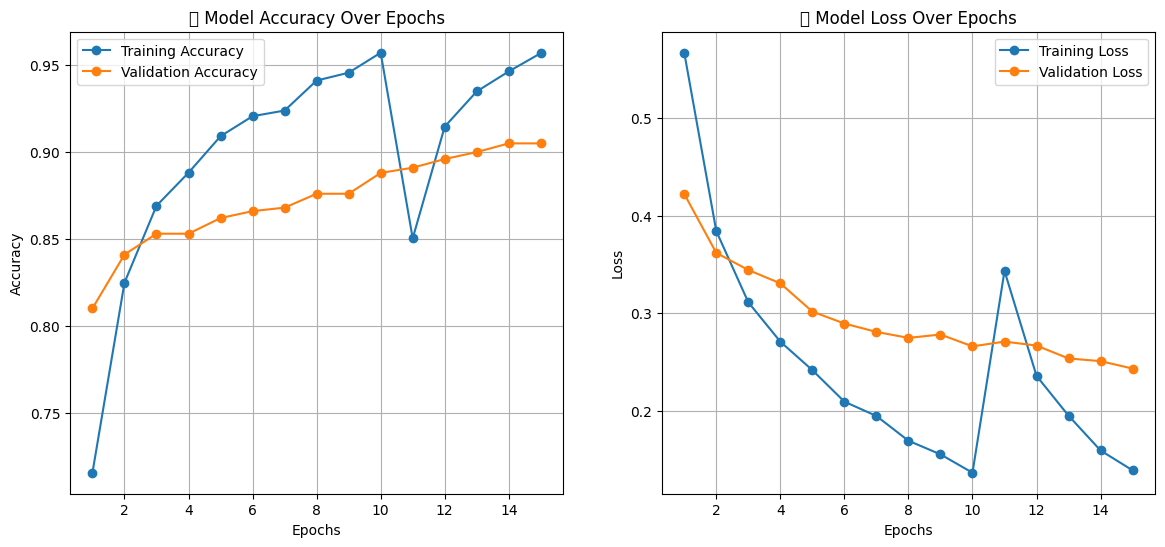

In [ ]:
import matplotlib.pyplot as plt

# Combine both history objects if fine-tuning was used
acc = history.history['accuracy'] + history2.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']
loss = history.history['loss'] + history2.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14,6))

# ---- Accuracy Graph ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('📈 Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# ---- Loss Graph ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('📉 Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive"))

['How to get started with Drive.pdf', '20230604_144502.jpg', 'CV_2023081519253648.pdf', 'VIT 2.pdf', 'VIT.pdf', 'Colab Notebooks', 'CoinbaseWalletBackups', 'Vinayak G Gaonkar.pdf', '20240228_110637.jpg', 'Bacterial leaf blight-20200814T055237Z-001', 'Brown spot-20200814T055208Z-001', 'Leaf smut-20200814T055530Z-001', 'PRCP_1002_Handwritten Digits Recognition .ipynb', 'entry-level-data-scientist2 - Template 17.gdoc', 'Vinayak.pdf', 'Course+Material', 'Vinayak2.pdf', 'Certificate.pdf', 'Certificate (1).pdf', 'Screenshot_20241015_174238_GPay.jpg', 'Untitled form.gform', 'Basics of Python.pdf', 'Numpy Modules (1).ipynb', '24130600014_VinayakGGaonkar_CSA.jpg', 'denver_extract.mp3', 'GATE', 'Screenshot_20250610_212117_PhonePe.jpg', 'Leads.gsheet', 'Potential_Customer.gsheet', 'Research Paper Analysis and Synthesis.gdoc', 'Vinayakggaonkar_resume-1 (1).pdf', 'vinayak (1).jpg', 'Vinayakggaonkar_resume-1.pdf', 'IMG-20251028-WA0052.jpg', 'instagram_1678966043594.mp4', 'debug_out_frame.jpg', 'deep

In [ ]:
print(os.listdir("/content/drive/MyDrive/Violence Detection"))

['dataset']


In [ ]:
import os

found = False
for root, dirs, files in os.walk("/content/drive/MyDrive"):
    for file in files:
        if file.endswith(".h5"):
            print("FOUND:", os.path.join(root, file))
            found = True

if not found:
    print("❌ No .h5 model found in Drive.")


FOUND: /content/drive/MyDrive/Course+Material/Course Material/Supervised Machine Learning/Neural Networks for Classification_TF/mnist_TF.h5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save("/content/drive/MyDrive/Violence Detection/violence_mobilenetV2_FINAL.h5")
print("Model saved ✔")

Model saved ✔


In [ ]:
print(os.listdir("/content/drive/MyDrive/Violence Detection"))

['dataset', 'violence_mobilenetV2_FINAL.h5']


# Save the model in .keras format

In [ ]:
model.save("/content/drive/MyDrive/Violence Detection/violence_mobilenetV2_FINAL.keras")
print("Model saved in new `.keras` format ✔")

Model saved in new `.keras` format ✔


Verify the file exists

In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/Violence Detection"))

['dataset', 'violence_mobilenetV2_FINAL.h5', 'violence_mobilenetV2_FINAL.keras']


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Violence Detection/violence_mobilenetV2_FINAL.keras")
print("Model loaded Successfully ✔")

Model loaded Successfully ✔


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 38 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Generate predictions
val_preds = model.predict(X_val)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities → 0 or 1


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_val, val_preds)

print("Classification Report:\n")
print(classification_report(y_val, val_preds))


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       500
           1       0.94      0.90      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



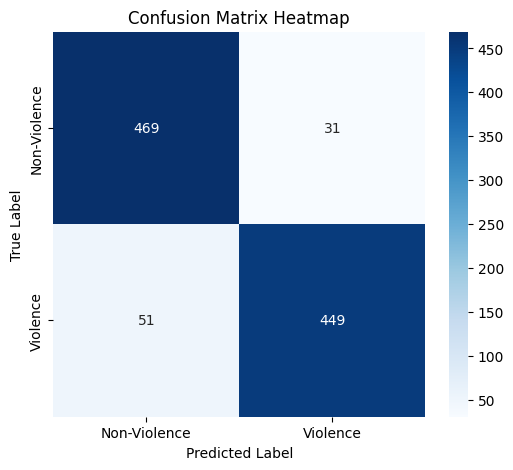

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Violence', 'Violence'],
            yticklabels=['Non-Violence', 'Violence'])

plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Importing video for testing

In [ ]:
from google.colab import files

uploaded = files.upload()
video_file = list(uploaded.keys())[0]
video_path = "/content/" + video_file

print("Uploaded:", video_path)


Saving V_93.mp4 to V_93.mp4
Uploaded: /content/V_93.mp4


In [ ]:
import cv2
import numpy as np

def extract_frames(video_path, num_frames=FRAMES_PER_VIDEO, img_size=IMG_SIZE):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        cap.release()
        return np.array([])

    frame_indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (img_size, img_size))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame / 255.0
            frames.append(frame)

    cap.release()
    return np.array(frames)


In [ ]:
def predict_video(video_path, model, num_frames=FRAMES_PER_VIDEO):
    frames = extract_frames(video_path, num_frames=num_frames)

    if frames.size == 0:
        return "❌ No frames extracted — invalid or corrupted video."

    preds = model.predict(frames)
    probability = preds.mean()

    print(f"\nViolence Probability: {probability:.4f}")

    if probability >= 0.5:
        return "🟥 RESULT: VIOLENCE DETECTED"
    else:
        return "🟩 RESULT: NON-VIOLENCE"

result = predict_video(video_path, model)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Violence Probability: 0.9997
🟥 RESULT: VIOLENCE DETECTED
